In [1]:
try:
    from sklearnex import patch_sklearn, unpatch_sklearn
    patch_sklearn()
except:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


説明変数 = temperature, sunhour1, sunhour2, insolation, month, hour, dayofweek
訓練スコア = 0.830618, 検証スコア = 0.828386


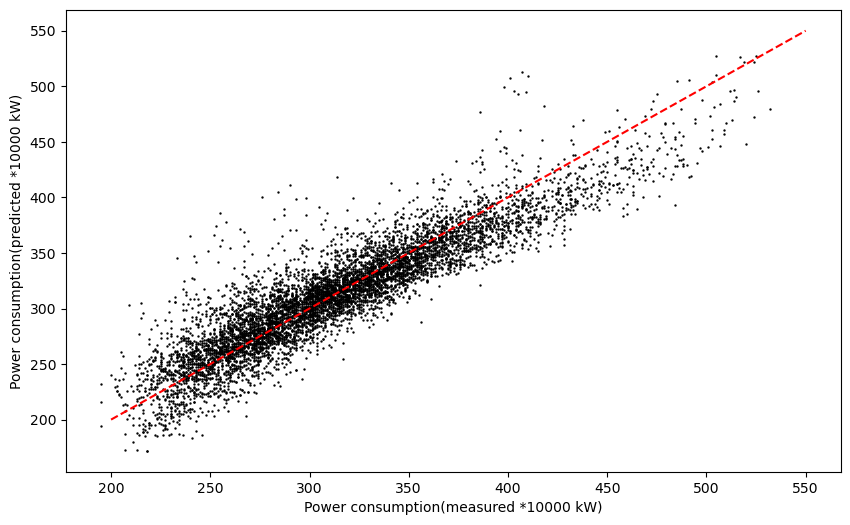

In [2]:
# coding: utf-8
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 四国電力の電力消費量データを読み込み
ed = [pd.read_csv(
    'data/juyo_shikoku_{:d}.csv'.format(year),
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col = "date_hour")
    for year in [2017, 2018, 2019, 2020]
]
elec_data = pd.concat(ed)

# 複数年の気象データを読み込み
tp = [pd.read_csv(
    './data/takamatsu{:d}.csv'.format(year),
    skiprows=5,
    names=['DATETIME', 'temperature', 'temperature2', 'temperature3', 
           'sunhour1','sunhour2','sunhour3','sunhour4',
           'insolation','insolation2','insolation3',
           'humid','humid2','humid3'],
    parse_dates={'date_hour': ["DATETIME"]},
    index_col='date_hour')
    for year in [2017, 2018, 2019, 2020]
]

tmp = pd.concat(tp)

# 月, 日, 時の取得
tmp["month"] = tmp.index.month
tmp['day'] = tmp.index.day
tmp['dayofyear'] = tmp.index.dayofyear
tmp['hour'] = tmp.index.hour
tmp['dayofweek'] = tmp.index.dayofweek

# 気象データと電力消費量データをいったん統合して時間軸を合わせたうえで、再度分割
#variable = ["temperature","sunhour1","month","hour"]
variable = ["temperature","sunhour1","sunhour2","insolation","month","hour","dayofweek"]
# variable = ["temperature","month","hour","dayofweek"]


takamatsu_wthr = elec_data.join(tmp[variable]).dropna()
dmy_dayofweek =pd.get_dummies( takamatsu_wthr['dayofweek'], prefix='dwk',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_dayofweek], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('dayofweek',axis=1)

dmy_hour =pd.get_dummies( takamatsu_wthr['hour'], prefix='h',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_hour], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('hour',axis=1)

dmy_month =pd.get_dummies( takamatsu_wthr['month'], prefix='m',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_month], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('month',axis=1)

takamatsu_elec = takamatsu_wthr.pop("consumption")

# from sklearn.preprocessing import PolynomialFeatures
# pf = PolynomialFeatures(degree=3, include_bias=False)
# takamatsu_wthr = pf.fit_transform(takamatsu_wthr)
# takamatsu_wthr = pd.DataFrame(takamatsu_wthr, columns=pf.get_feature_names_out())
takamatsu_wthr["temp2"] = takamatsu_wthr["temperature"]**2
takamatsu_wthr["temp3"] = takamatsu_wthr["temperature"]**3
takamatsu_wthr["sun1x"] = takamatsu_wthr["sunhour1"]**2
takamatsu_wthr["sun2x"] = takamatsu_wthr["sunhour2"]**2
takamatsu_wthr["insolation2"] = takamatsu_wthr["insolation"]**2


# 学習と性能の評価
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# 学習データとテストデータに分割
x_train, x_test, y_train, y_test = train_test_split(
    takamatsu_wthr, takamatsu_elec, test_size=0.2, random_state=0)


# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
x_train_normed = scaler.fit_transform(x_train)
# テストデータも標準化
x_test_normed = scaler.transform(x_test)

scaler2 = StandardScaler()
y_train_normed = scaler2.fit_transform(pd.DataFrame(y_train))
y_test_normed = scaler2.transform(pd.DataFrame(y_test))

model.fit(x_train_normed, y_train_normed.ravel())

score = "説明変数 = {}\n訓練スコア = {:f}, 検証スコア = {:f}".format(
          ", ".join(variable),
          model.score(x_train_normed, y_train_normed),
          model.score(x_test_normed, y_test_normed)
          )

print (score)

# -- 可視化 --
# 画像のサイズを設定する
plt.figure(figsize=(10, 6))

predicted = model.predict(x_test_normed)

plt.xlabel('Power consumption(measured *10000 kW)')
plt.ylabel('Power consumption(predicted *10000 kW)')
plt.scatter(scaler2.inverse_transform(y_test_normed), scaler2.inverse_transform(predicted.reshape(-1,1)), s=0.5, color="black")
plt.plot([200, 550], [200, 550], 'r--')

#plt.savefig("predict-power-consumption-graph.png")
plt.show()


In [3]:
# modelの保存
import joblib

filename ='weather-elec.pkl'
joblib.dump(model, open(filename, 'wb'))

# Scaleの保存
fname = "scaler.pkl"
joblib.dump(scaler, open(fname, 'wb'))
fname = "scaler2.pkl"
joblib.dump(scaler2, open(fname, 'wb'))

### 欠損値の確認

In [5]:
takamatsu_wthr = elec_data.join(tmp[variable])
takamatsu_wthr[takamatsu_wthr.isnull().any(axis=1)]

,consumption,temperature,sunhour1,sunhour2,insolation,month,hour,dayofweek
date_hour,,,,,,,,
2017-01-01 00:00:00,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-09 10:00:00,328,NaN,NaN,NaN,NaN,11.0,10.0,3.0
2017-11-09 11:00:00,328,NaN,NaN,NaN,NaN,11.0,11.0,3.0
2017-11-09 12:00:00,308,17.7,NaN,NaN,NaN,11.0,12.0,3.0
2017-11-09 13:00:00,329,NaN,NaN,NaN,NaN,11.0,13.0,3.0
2017-11-09 14:00:00,328,NaN,NaN,NaN,NaN,11.0,14.0,3.0
2017-11-09 15:00:00,328,18.1,NaN,NaN,NaN,11.0,15.0,3.0
2017-11-09 16:00:00,332,NaN,NaN,NaN,NaN,11.0,16.0,3.0
2017-11-09 17:00:00,338,NaN,NaN,NaN,NaN,11.0,17.0,3.0
